## Faster `index_copy` operations

In [1]:
import os
os.environ['LIBTPU_INIT_ARGS']='--xla_tpu_scoped_vmem_limit_kib=98304 --xla_tpu_use_minor_sharding_for_major_trivial_input=true --xla_tpu_relayout_group_size_threshold_for_reduce_scatter=1 --xla_tpu_assign_all_reduce_scatter_layout=true --xla_tpu_enable_data_parallel_all_reduce_opt=true --xla_tpu_data_parallel_opt_different_sized_ops=true --xla_tpu_enable_async_collective_fusion=true --xla_tpu_enable_async_collective_fusion_fuse_all_gather=true --xla_tpu_enable_async_collective_fusion_multiple_steps=true  --xla_tpu_overlap_compute_collective_tc=true  --xla_enable_async_all_gather=true --xla_tpu_enable_async_collective_fusion_fuse_all_reduce=false  --xla_tpu_enable_sparse_core_collective_offload_all_reduce=true --xla_tpu_use_tc_device_shape_on_sc=true  --xla_sc_disable_megacore_partitioning=true  --2a886c8_chip_config_name=megachip_tccontrol'

In [2]:
# SPDX-License-Identifier: Apache-2.0
# SPDX-FileCopyrightText: Copyright contributors to the vLLM project

import functools

import jax
from jax.experimental import pallas as pl
from jax.experimental.pallas import tpu as pltpu


def cdiv(a, b) -> int:
    return -(a // -b)


def _kv_cache_update_kernel(
    # Prefetch
    slices_ref,  # [3, padded_num_slices], list of (kv_cache_start,
    # new_kv_start, slice_len)
    # Input
    new_kv_hbm_ref,  # [num_tokens, num_combined_kv_heads, head_dim]
    kv_cache_hbm_ref,  # [total_num_pages * page_size, num_combined_kv_heads,
    # head_dim]
    # Output
    _,  # [total_num_pages * page_size, num_combined_kv_heads, head_dim]
    # Scratch
    scratch,  # [num_slices_per_block, page_size, num_combined_kv_heads,
    # head_dim]
    sem,
):
    async_copies = []
    block_idx = pl.program_id(0)
    num_slices_per_block = scratch.shape[0]

    # Copy from new_kv_hbm_ref to scratch
    for i in range(num_slices_per_block):
        offset_i = i + block_idx * num_slices_per_block
        new_kv_start = slices_ref[1, offset_i]
        length = slices_ref[2, offset_i]
        async_copy = pltpu.make_async_copy(
            new_kv_hbm_ref.at[pl.ds(new_kv_start, length), ...],
            scratch.at[i, pl.ds(0, length), ...],
            sem,
        )
        async_copy.start()
        async_copies.append(async_copy)

    for async_copy in async_copies:
        async_copy.wait()

    # Copy from scratch to kv_cache_hbm_ref
    async_copies.clear()
    for i in range(num_slices_per_block):
        offset_i = i + block_idx * num_slices_per_block
        kv_cache_start = slices_ref[0, offset_i]
        length = slices_ref[2, offset_i]
        async_copy = pltpu.make_async_copy(
            scratch.at[i, pl.ds(0, length), ...],
            kv_cache_hbm_ref.at[pl.ds(kv_cache_start, length), ...],
            sem,
        )
        async_copy.start()
        async_copies.append(async_copy)
    for async_copy in async_copies:
        async_copy.wait()


@functools.partial(
    jax.jit,
    static_argnames=["page_size", "num_slices_per_block"],
)
def kv_cache_update(
    new_kv: jax.Array,  # [total_num_token, num_combined_kv_heads, head_dim]
    slices: jax.
    Array,  # [3, slices], list of (kv_cache_start, new_kv_start, slice_len)
    kv_cache: jax.
    Array,  # [total_num_pages * page_size, num_combined_kv_heads, head_dim]
    num_kv_update_slices: jax.Array,  # [1]
    *,
    page_size: int = 32,
    num_slices_per_block: int = 8,
):
    assert slices.shape[1] % num_slices_per_block == 0
    _, num_combined_kv_heads, head_dim = new_kv.shape
    assert kv_cache.shape[1] == num_combined_kv_heads
    assert kv_cache.shape[2] == head_dim
    assert head_dim % 128 == 0
    # TODO: Add dynamic check to make sure that the all the slice lengths are
    # smaller or equal to page_size

    in_specs = [
        pl.BlockSpec(memory_space=pltpu.TPUMemorySpace.ANY),
        pl.BlockSpec(memory_space=pltpu.TPUMemorySpace.ANY),
    ]

    out_specs = [pl.BlockSpec(memory_space=pltpu.TPUMemorySpace.ANY)]
    out_shape = [jax.ShapeDtypeStruct(kv_cache.shape, dtype=kv_cache.dtype)]

    scalar_prefetches = [slices]
    scratch = pltpu.VMEM(
        (num_slices_per_block, page_size, num_combined_kv_heads, head_dim),
        new_kv.dtype,
    )

    scratch_shapes = [
        scratch,
        pltpu.SemaphoreType.DMA,
    ]

    kernel = pl.pallas_call(
        _kv_cache_update_kernel,
        grid_spec=pltpu.PrefetchScalarGridSpec(
            num_scalar_prefetch=len(scalar_prefetches),
            in_specs=in_specs,
            out_specs=out_specs,
            grid=(cdiv(num_kv_update_slices[0], num_slices_per_block), ),
            scratch_shapes=scratch_shapes,
        ),
        out_shape=out_shape,
        input_output_aliases={len(scalar_prefetches) + 1: 0},
    )

    return kernel(*scalar_prefetches, new_kv, kv_cache)[0]

In [3]:
# Benchmarking harness
import gc  # type: ignore
import torchax
import torchax.interop
from dataclasses import dataclass
import jax
import jax.numpy as jnp
import numpy as np
from functools import partial
from xprof_step_time.step_duration import step_duration_from_latest_profile


NUM_TOKENS_BENCH = 2048
KV_CACHE_NUM_PAGES = 5607
PAGE_SIZE = 64
HEAD_SIZE = 128


@dataclass
class Fixture:
  kv_cache: jax.Array
  new_kv: jax.Array
  slot_mapping: jax.Array
  slices: jax.Array


def make_fixture(num_slices_per_block=8) -> Fixture:
  keys = jax.random.split(jax.random.PRNGKey(42), 3)
  kv_cache = jax.random.normal(keys[0], (KV_CACHE_NUM_PAGES, PAGE_SIZE, 4, HEAD_SIZE)).astype(jnp.bfloat16)
  new_kv = jax.random.normal(keys[1], (NUM_TOKENS_BENCH, 4, HEAD_SIZE)).astype(jnp.bfloat16)
  # Generate slot mapping of representative sizes:
  # 1024 prefill tokens, 512 prefill tokens, 512 decode tokens.
  # slot locations: [0-1023], [2048-2559], [512 random indices between 4000-]
  slices = []
  # kv_cache_start, new_kv_start, slice_len
  new_kv_start = 0
  for i in range(0, 1024, PAGE_SIZE):
    slices.append(jnp.array([0 + i, new_kv_start, PAGE_SIZE], dtype=jnp.int32))
    new_kv_start += PAGE_SIZE
  for i in range(0, 512, PAGE_SIZE):
    slices.append(jnp.array([2048 + i, new_kv_start, PAGE_SIZE], dtype=jnp.int32))
    new_kv_start += PAGE_SIZE
  # Generate 512 unique random indices from 4000 onwards.
  # If indices are not unique, we get data races!
  random_indices = jax.random.permutation(keys[2], jnp.arange(4000, KV_CACHE_NUM_PAGES * PAGE_SIZE))[:512]
  for i in range(512):
    kv_cache_start = random_indices[i]
    slice_len = 1
    slices.append(jnp.array([kv_cache_start, new_kv_start, slice_len], dtype=jnp.int32))
    new_kv_start += slice_len
  assert new_kv_start == NUM_TOKENS_BENCH, "new_kv_start should match the number of tokens benchmarked"
  assert new_kv_start <= kv_cache.shape[0] * kv_cache.shape[1], "new_kv_start should not exceed kv_cache size"
  slices = jnp.stack(slices, axis=0)

  # Round up to a multiple of num_slices_per_block slices
  num_slices = len(slices)
  num_slices_rounded = (num_slices + num_slices_per_block - 1) // num_slices_per_block * num_slices_per_block
  slices = jnp.pad(slices, ((0, num_slices_rounded - num_slices), (0, 0)), mode='constant', constant_values=0)
  # Derive the slot mapping based on slices
  slot_mapping = np.zeros(NUM_TOKENS_BENCH, dtype=np.int32) + 1000000000
  for i in range(slices.shape[0]):
    kv_cache_start, new_kv_start, slice_len = slices[i, :]
    if slice_len == 0:
      continue
    slot_mapping[new_kv_start:new_kv_start + slice_len] = np.arange(kv_cache_start, kv_cache_start + slice_len)
  assert np.all(slot_mapping < kv_cache.shape[0] * kv_cache.shape[1]), "slot_mapping indices should be within kv_cache bounds"
  return Fixture(
      kv_cache=kv_cache,
      new_kv=new_kv,
      slot_mapping=jnp.array(slot_mapping, dtype=jnp.int32),
      slices=slices.transpose().astype(jnp.int32),
  )


@partial(
  jax.jit,
  donate_argnums=(0,),
  static_argnames=["page_size", "num_slices_per_block"],
)
def sliced_copy(kv_cache, new_kv, slot_mapping, slices, page_size=PAGE_SIZE, num_slices_per_block=8):
  num_blocks = kv_cache.shape[0]
  block_size = kv_cache.shape[1]
  flat_kv_cache = kv_cache.reshape(-1, *kv_cache.shape[2:])
  num_kv_update_slices = jnp.array([slices.shape[1]], dtype=jnp.int32)
  flat_kv_cache = kv_cache_update(new_kv, slices, flat_kv_cache, num_kv_update_slices, page_size=page_size, num_slices_per_block=num_slices_per_block)
  return flat_kv_cache.reshape(num_blocks, block_size, *kv_cache.shape[2:])


def reference_index_copy(kv_cache, new_kv, slot_mapping):
  assert new_kv.shape[0] == slot_mapping.shape[0]
  assert new_kv.shape[1:] == kv_cache.shape[2:]
  return kv_cache.flatten(0, 1).index_copy(0, slot_mapping, new_kv).reshape(kv_cache.shape)


def benchmark_index_copy(copier, **kwargs):
  print(f"Running benchmark for {copier.__name__}...")
  if "num_slices_per_block" in kwargs:
    num_slices_per_block = kwargs["num_slices_per_block"]
  else:
    num_slices_per_block = 8
  fixture = make_fixture(num_slices_per_block=num_slices_per_block)
  gc.collect()
  all_outputs = []
  jax.block_until_ready(jax.live_arrays())
  NUM_STEPS = 10
  PROFILE_DIR = 'profile/index_copy_pallas'
  os.makedirs(PROFILE_DIR, exist_ok=True)
  slot_mapping = fixture.slot_mapping
  new_kv = fixture.new_kv
  slices = fixture.slices
  kv_caches = [fixture.kv_cache.copy() for _ in range(NUM_STEPS)]
  # Warm up
  key = jax.random.key(123)
  dummy_kv_cache = jax.random.normal(key, (KV_CACHE_NUM_PAGES, PAGE_SIZE, 4, HEAD_SIZE)).astype(jnp.bfloat16)
  dummy_kv_cache_copy = dummy_kv_cache.copy()
  updated_kv_cache = jax.block_until_ready(copier(dummy_kv_cache, new_kv, slot_mapping, slices, **kwargs))
  # Verify correctness
  expected_kv_cache = torchax.interop.jax_view(reference_index_copy)(dummy_kv_cache_copy, new_kv, slot_mapping)
  if not jnp.all(updated_kv_cache == expected_kv_cache):
    indices = jnp.nonzero(updated_kv_cache != expected_kv_cache)
    raise ValueError(f"""{copier.__name__} did not copy the new_kv correctly.

Indices of locations that differ:
{jnp.array(indices).transpose()}
""")
  # Start profiling
  jax.profiler.start_trace(PROFILE_DIR)
  for i in range(NUM_STEPS):
    all_outputs.append(copier(kv_caches[i], new_kv, slot_mapping, fixture.slices, **kwargs))
  jax.block_until_ready(all_outputs)
  jax.profiler.stop_trace()
  step_time = step_duration_from_latest_profile(PROFILE_DIR, ignore_gaps=True, verbose=False)
  bytes_copied = new_kv.size * new_kv.dtype.itemsize
  print(f"Execution took {step_time * 1000:.4f} ms. Bytes copied: {bytes_copied} bytes.")
  throughput = bytes_copied / step_time
  print(f"Throughput: {throughput / 1e9:.2f} GB/s.")
  return throughput


In [4]:
realistic_pallas_perf = {}
realistic_pallas_perf["8 slice"] = benchmark_index_copy(sliced_copy, num_slices_per_block=8)
realistic_pallas_perf["16 slice"] = benchmark_index_copy(sliced_copy, num_slices_per_block=16)
realistic_pallas_perf["32 slice"] = benchmark_index_copy(sliced_copy, num_slices_per_block=32)
realistic_pallas_perf["64 slice"] = benchmark_index_copy(sliced_copy, num_slices_per_block=64)
realistic_pallas_perf["128 slice"] = benchmark_index_copy(sliced_copy, num_slices_per_block=128)
realistic_pallas_perf["256 slice"] = benchmark_index_copy(sliced_copy, num_slices_per_block=256)
gc.collect()

Running benchmark for sliced_copy...


/tmp/ipykernel_14922/3276691991.py:91: DeprecationWarning: TPUMemorySpace is deprecated, use MemorySpace instead.
  pl.BlockSpec(memory_space=pltpu.TPUMemorySpace.ANY),
2025-07-02 22:37:02.004830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751521022.018856   14922 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751521022.022883   14922 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751521022.035635   14922 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751521022.035650   14922 computation_placer.cc:177] computation placer already r

Execution took 0.0745 ms. Bytes copied: 2097152 bytes.
Throughput: 28.15 GB/s.
Running benchmark for sliced_copy...
Execution took 0.0456 ms. Bytes copied: 2097152 bytes.
Throughput: 45.94 GB/s.
Running benchmark for sliced_copy...
Execution took 0.0304 ms. Bytes copied: 2097152 bytes.
Throughput: 68.87 GB/s.
Running benchmark for sliced_copy...
Execution took 0.0239 ms. Bytes copied: 2097152 bytes.
Throughput: 87.85 GB/s.
Running benchmark for sliced_copy...
Execution took 0.0229 ms. Bytes copied: 2097152 bytes.
Throughput: 91.65 GB/s.
Running benchmark for sliced_copy...
Execution took 0.0273 ms. Bytes copied: 2097152 bytes.
Throughput: 76.76 GB/s.


453

# Pipeline copy-to-VMEM with copy-to-HBM

Instead of waiting for all HBM-to-VMEM transfers to finish before moving to the
next stage, we start the corresponding VMEM-to-HBM copy as soon as the upstream
HBM-to-VMEM copy has finished. This will overlap transfers in/out of VMEM.

In [5]:
# SPDX-License-Identifier: Apache-2.0
# SPDX-FileCopyrightText: Copyright contributors to the vLLM project

import functools

import jax
from jax.experimental import pallas as pl
from jax.experimental.pallas import tpu as pltpu


def cdiv(a, b) -> int:
    return -(a // -b)


def _faster_kv_cache_update_kernel(
    # Prefetch
    slices_ref,  # [3, padded_num_slices], list of (kv_cache_start,
    # new_kv_start, slice_len)
    # Input
    new_kv_hbm_ref,  # [num_tokens, num_combined_kv_heads, head_dim]
    kv_cache_hbm_ref,  # [total_num_pages * page_size, num_combined_kv_heads,
    # head_dim]
    # Output
    _,  # [total_num_pages * page_size, num_combined_kv_heads, head_dim]
    # Scratch
    scratch,  # [num_slices_per_block, page_size, num_combined_kv_heads,
    # head_dim]
    sem,
):
    async_copies_in = []
    block_idx = pl.program_id(0)
    num_slices_per_block = scratch.shape[0]

    # Copy from new_kv_hbm_ref to scratch
    for i in range(num_slices_per_block):
        offset_i = i + block_idx * num_slices_per_block
        new_kv_start = slices_ref[1, offset_i]
        length = slices_ref[2, offset_i]
        async_copy = pltpu.make_async_copy(
            new_kv_hbm_ref.at[pl.ds(new_kv_start, length), ...],
            scratch.at[i, pl.ds(0, length), ...],
            sem,
        )
        async_copy.start()
        async_copies_in.append(async_copy)

    # Copy from scratch to kv_cache_hbm_ref
    async_copies_out = []
    for i in range(num_slices_per_block):
        offset_i = i + block_idx * num_slices_per_block
        kv_cache_start = slices_ref[0, offset_i]
        length = slices_ref[2, offset_i]
        async_copies_in[i].wait()
        async_copy = pltpu.make_async_copy(
            scratch.at[i, pl.ds(0, length), ...],
            kv_cache_hbm_ref.at[pl.ds(kv_cache_start, length), ...],
            sem,
        )
        async_copy.start()
        async_copies_out.append(async_copy)
    for async_copy in async_copies_out:
        async_copy.wait()


@functools.partial(
    jax.jit,
    static_argnames=["page_size", "num_slices_per_block"],
)
def faster_kv_cache_update(
    new_kv: jax.Array,  # [total_num_token, num_combined_kv_heads, head_dim]
    slices: jax.
    Array,  # [3, slices], list of (kv_cache_start, new_kv_start, slice_len)
    kv_cache: jax.
    Array,  # [total_num_pages * page_size, num_combined_kv_heads, head_dim]
    num_kv_update_slices: jax.Array,  # [1]
    *,
    page_size: int = 32,
    num_slices_per_block: int = 8,
):
    assert slices.shape[1] % num_slices_per_block == 0
    _, num_combined_kv_heads, head_dim = new_kv.shape
    assert kv_cache.shape[1] == num_combined_kv_heads
    assert kv_cache.shape[2] == head_dim
    assert head_dim % 128 == 0
    # TODO: Add dynamic check to make sure that the all the slice lengths are
    # smaller or equal to page_size

    in_specs = [
        pl.BlockSpec(memory_space=pltpu.TPUMemorySpace.ANY),
        pl.BlockSpec(memory_space=pltpu.TPUMemorySpace.ANY),
    ]

    out_specs = [pl.BlockSpec(memory_space=pltpu.TPUMemorySpace.ANY)]
    out_shape = [jax.ShapeDtypeStruct(kv_cache.shape, dtype=kv_cache.dtype)]

    scalar_prefetches = [slices]
    scratch = pltpu.VMEM(
        (num_slices_per_block, page_size, num_combined_kv_heads, head_dim),
        new_kv.dtype,
    )

    scratch_shapes = [
        scratch,
        pltpu.SemaphoreType.DMA,
    ]

    kernel = pl.pallas_call(
        _faster_kv_cache_update_kernel,
        grid_spec=pltpu.PrefetchScalarGridSpec(
            num_scalar_prefetch=len(scalar_prefetches),
            in_specs=in_specs,
            out_specs=out_specs,
            grid=(cdiv(num_kv_update_slices[0], num_slices_per_block), ),
            scratch_shapes=scratch_shapes,
        ),
        out_shape=out_shape,
        input_output_aliases={len(scalar_prefetches) + 1: 0},
    )

    return kernel(*scalar_prefetches, new_kv, kv_cache)[0]


@partial(
  jax.jit,
  donate_argnums=(0,),
  static_argnames=["page_size", "num_slices_per_block"],
)
def faster_sliced_copy(kv_cache, new_kv, slot_mapping, slices, page_size=PAGE_SIZE, num_slices_per_block=8):
  num_blocks = kv_cache.shape[0]
  block_size = kv_cache.shape[1]
  flat_kv_cache = kv_cache.reshape(-1, *kv_cache.shape[2:])
  num_kv_update_slices = jnp.array([slices.shape[1]], dtype=jnp.int32)
  flat_kv_cache = faster_kv_cache_update(new_kv, slices, flat_kv_cache, num_kv_update_slices, page_size=page_size, num_slices_per_block=num_slices_per_block)
  return flat_kv_cache.reshape(num_blocks, block_size, *kv_cache.shape[2:])


In [6]:
realistic_pallas_perf["pipelined\n8 slice"] = benchmark_index_copy(faster_sliced_copy, num_slices_per_block=8)
realistic_pallas_perf["pipelined\n16 slice"] = benchmark_index_copy(faster_sliced_copy, num_slices_per_block=16)
realistic_pallas_perf["pipelined\n32 slice"] = benchmark_index_copy(faster_sliced_copy, num_slices_per_block=32)
realistic_pallas_perf["pipelined\n64 slice"] = benchmark_index_copy(faster_sliced_copy, num_slices_per_block=64)
realistic_pallas_perf["pipelined\n128 slice"] = benchmark_index_copy(faster_sliced_copy, num_slices_per_block=128)
realistic_pallas_perf["pipelined\n256 slice"] = benchmark_index_copy(faster_sliced_copy, num_slices_per_block=256)
gc.collect()

Running benchmark for faster_sliced_copy...
Execution took 0.0718 ms. Bytes copied: 2097152 bytes.
Throughput: 29.22 GB/s.
Running benchmark for faster_sliced_copy...
Execution took 0.0411 ms. Bytes copied: 2097152 bytes.
Throughput: 51.05 GB/s.
Running benchmark for faster_sliced_copy...
Execution took 0.0256 ms. Bytes copied: 2097152 bytes.
Throughput: 81.92 GB/s.
Running benchmark for faster_sliced_copy...
Execution took 0.0209 ms. Bytes copied: 2097152 bytes.
Throughput: 100.57 GB/s.
Running benchmark for faster_sliced_copy...
Execution took 0.0220 ms. Bytes copied: 2097152 bytes.
Throughput: 95.30 GB/s.
Running benchmark for faster_sliced_copy...
Execution took 0.0264 ms. Bytes copied: 2097152 bytes.
Throughput: 79.44 GB/s.


1077

# Use optimum number of slices per block

Find the optimum number of slices per block via grid search.

In [7]:
def next_power_of_2(x):
    import math
    if x == 0:
        return 1
    return 2 ** math.ceil(math.log2(x))


def compute_num_slices_per_block(kv_cache):
  """Find the optimum number of slices to copy per Pallas program instance.

  Increasing the number of slices copied in one instance of the kernel program
  will increase HBM bandwidth utilization via more in-flight DMAs.

  However, it will also use more VMEM, and experimentally, we observed performance
  regression at 128 slices on v6e, likely due to running out of scalar registers.
  Thus this function will limit the number of slices to 64.
  """
  num_pages, page_size, num_heads, head_dim = kv_cache.shape
  # Conservative VMEM usage limit: 32 MiB
  vmem_limit = 32 * 1024 * 1024
  num_slices_per_block = vmem_limit // (page_size * num_heads * head_dim)
  assert num_slices_per_block > 0, f"Number of slices should be positive"
  num_slices_per_block = next_power_of_2(num_slices_per_block)
  if num_slices_per_block > 64:
    num_slices_per_block = 64
  return num_slices_per_block


In [8]:
fixture = make_fixture()
compute_num_slices_per_block(fixture.kv_cache)

64

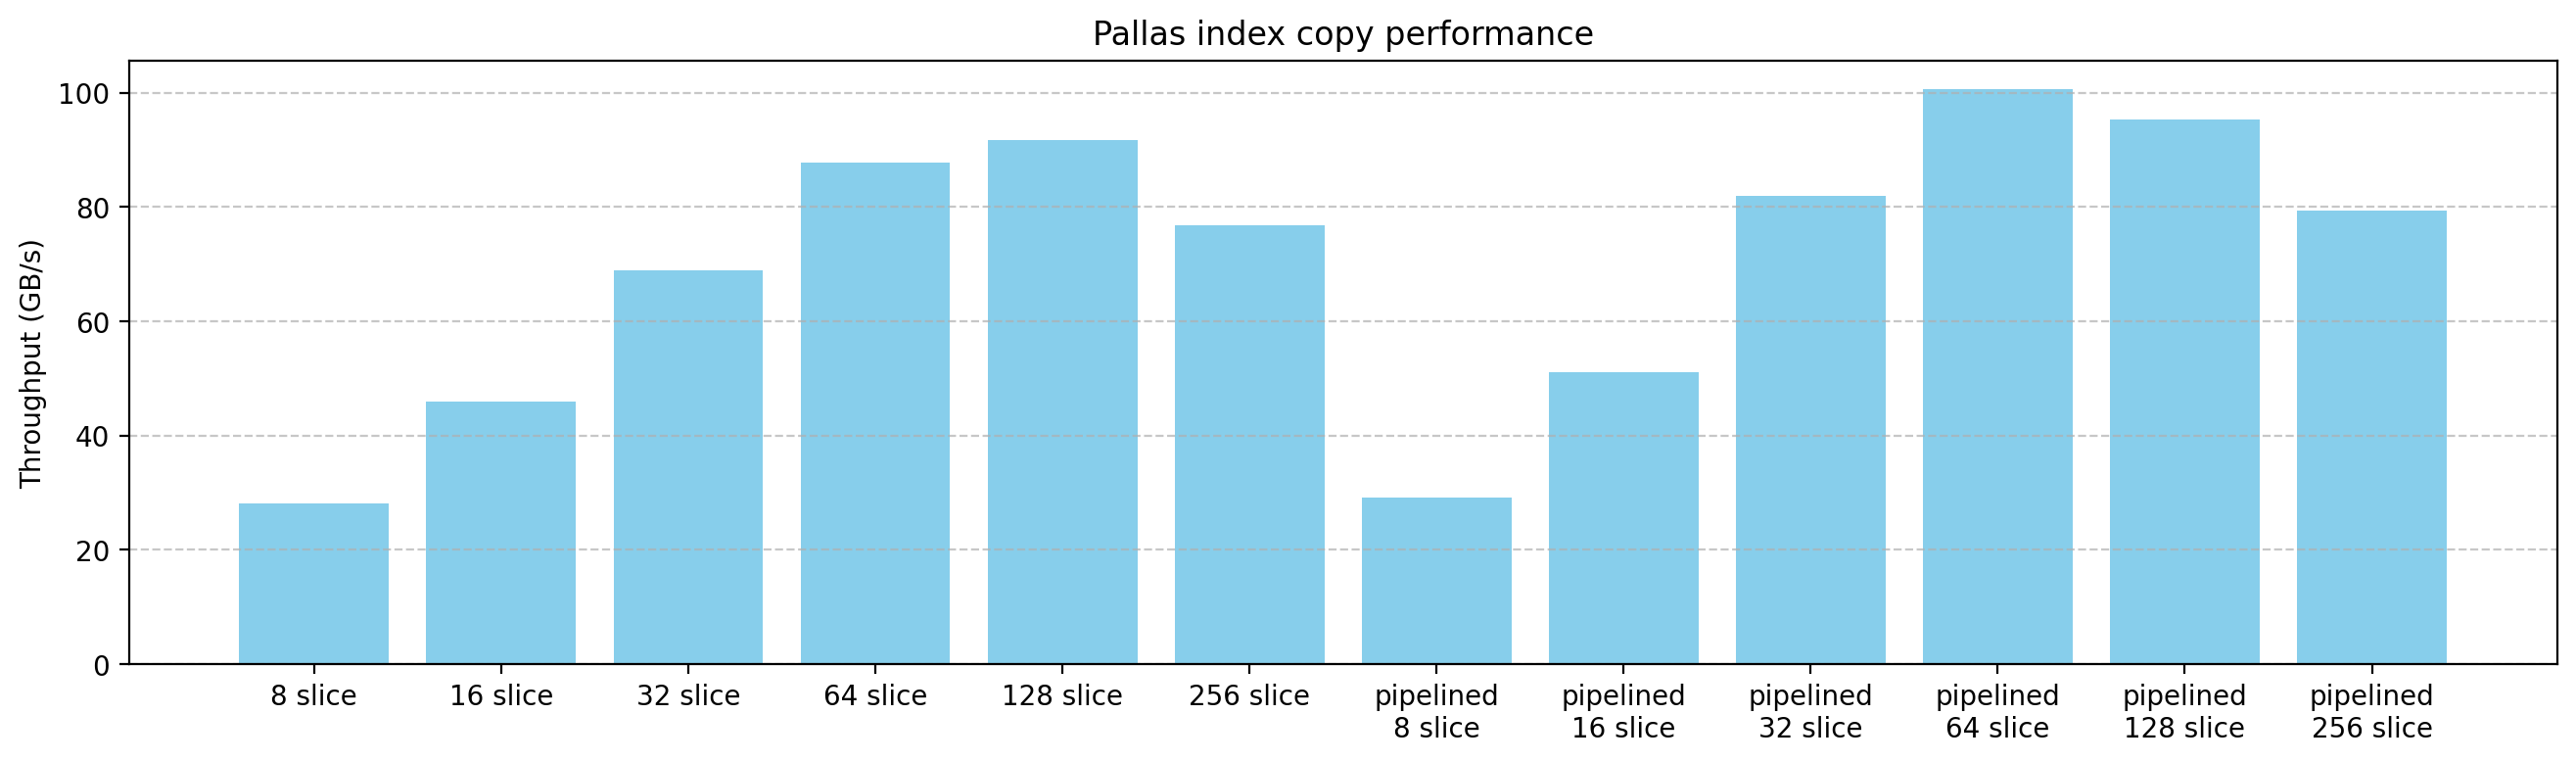

In [10]:
# Plot the results
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

def plot(pallas_perf):
  kernel_names = list(pallas_perf.keys())
  latencies = [v / 1e9 for v in pallas_perf.values()]

  plt.figure(figsize=(16, 4))
  plt.bar(kernel_names, latencies, color='skyblue')
  plt.ylabel('Throughput (GB/s)')
  plt.title('Pallas index copy performance')
  plt.xticks()
  plt.grid(axis='y', linestyle='--', alpha=0.7)

plot(realistic_pallas_perf)